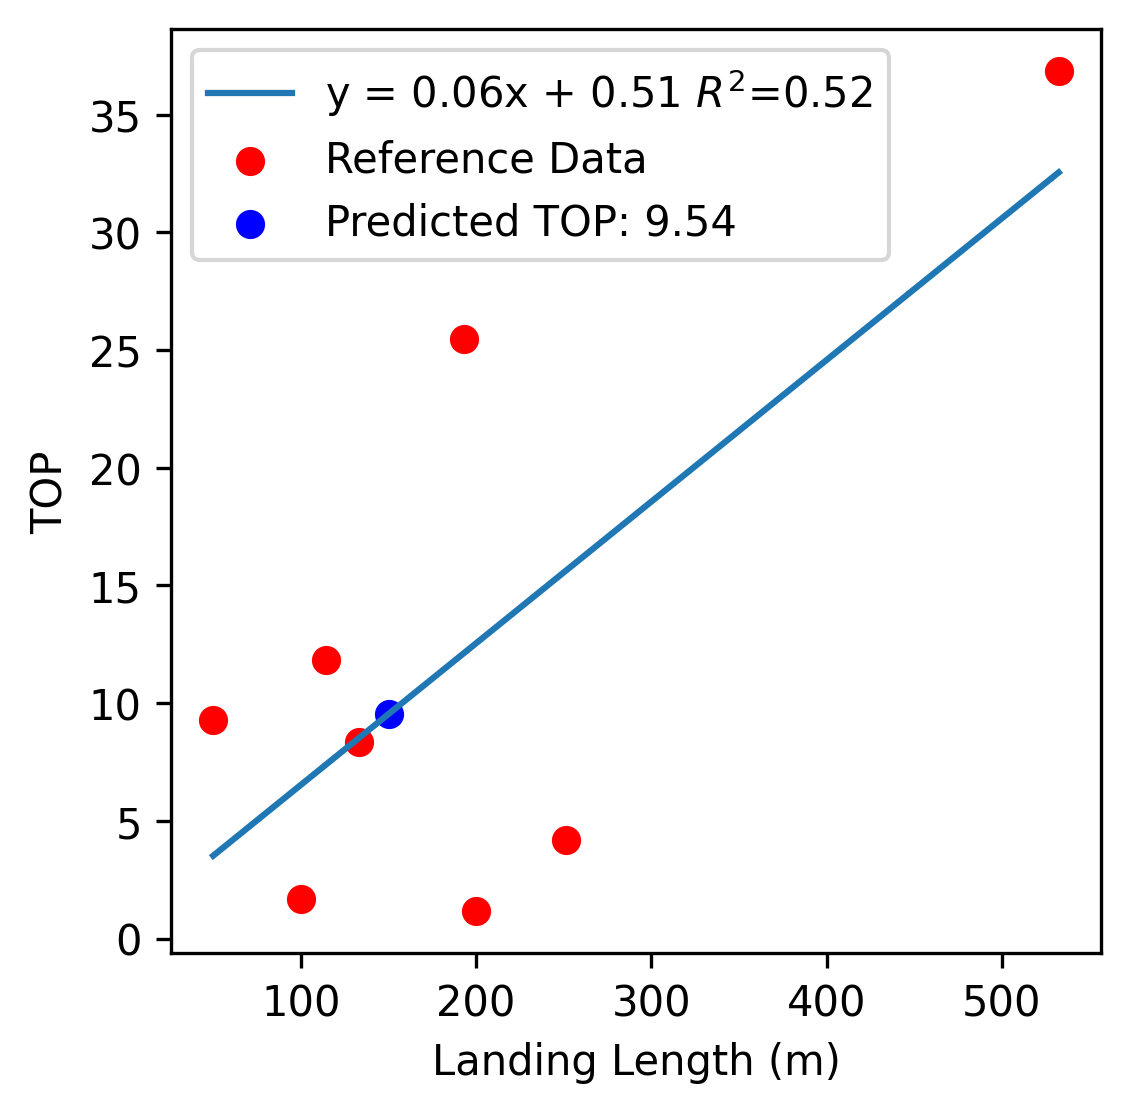

R^2: 0.5163796867780028
Predicted TOP for take_off_distance 150: 9.536338819297905


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Constants
g = 9.81
rho = 1.225
Clmax = [1.4,1.6,1.8]
Vs = 20
Sland = 191.646
c = 5
d = 0.5
take_off_distance = 150 #m

Clmax = np.array(Clmax)

W_s_stall = 0.5*rho*Vs**2*Clmax[0]

#TOP
TOP = [1.161342149, 25.45609524, 8.342975207, 4.172643701, 9.295800655, 1.661194904, 36.84901452, 11.81994298]
landing_length = [200, 192.8189593, 133.0875, 251.00894, 50, 99.9635, 532.35, 114.1012628]

TOP = np.array(TOP)
landing_length = np.array(landing_length)

# Reshape for fitting
TOP = TOP.reshape(-1, 1)
landing_length = landing_length.reshape(-1, 1)

# Fit the model
model = LinearRegression()
model.fit(landing_length, TOP)

# Get coefficients and intercept
b = model.coef_
c = model.intercept_

# Define the function for predictions
def f(x):
    return b * x + c

# Generate linear space for plotting
x_plot = np.linspace(landing_length.min(), landing_length.max(), 100).reshape(-1, 1)
y_plot = f(x_plot)

# Predict TOP for take_off_distance
take_off_distance = np.array(take_off_distance).reshape(-1, 1)
predicted_TOP = f(take_off_distance)[0][0]

# Plot the data and regression line
plt.figure(figsize=(4,4), dpi=300)
plt.plot(x_plot, y_plot, label=f'y = {b[0][0]:.2f}x + {c[0]:.2f} $R^2$={model.score(landing_length, TOP):.2f}')
plt.scatter(landing_length.flatten(), TOP.flatten(), color='red', label='Reference Data')
plt.scatter(take_off_distance.flatten(), predicted_TOP, color='blue', label=f'Predicted TOP: {predicted_TOP:.2f}')
plt.xlabel('Landing Length (m)')
plt.ylabel('TOP')
plt.legend()
plt.savefig('TOP_vs_Landing_Length.png', dpi=300)
plt.show()

# Calculate r2
r2 = model.score(landing_length, TOP)
print(f"R^2: {r2}")
print(f"Predicted TOP for take_off_distance {take_off_distance.flatten()[0]}: {predicted_TOP}")


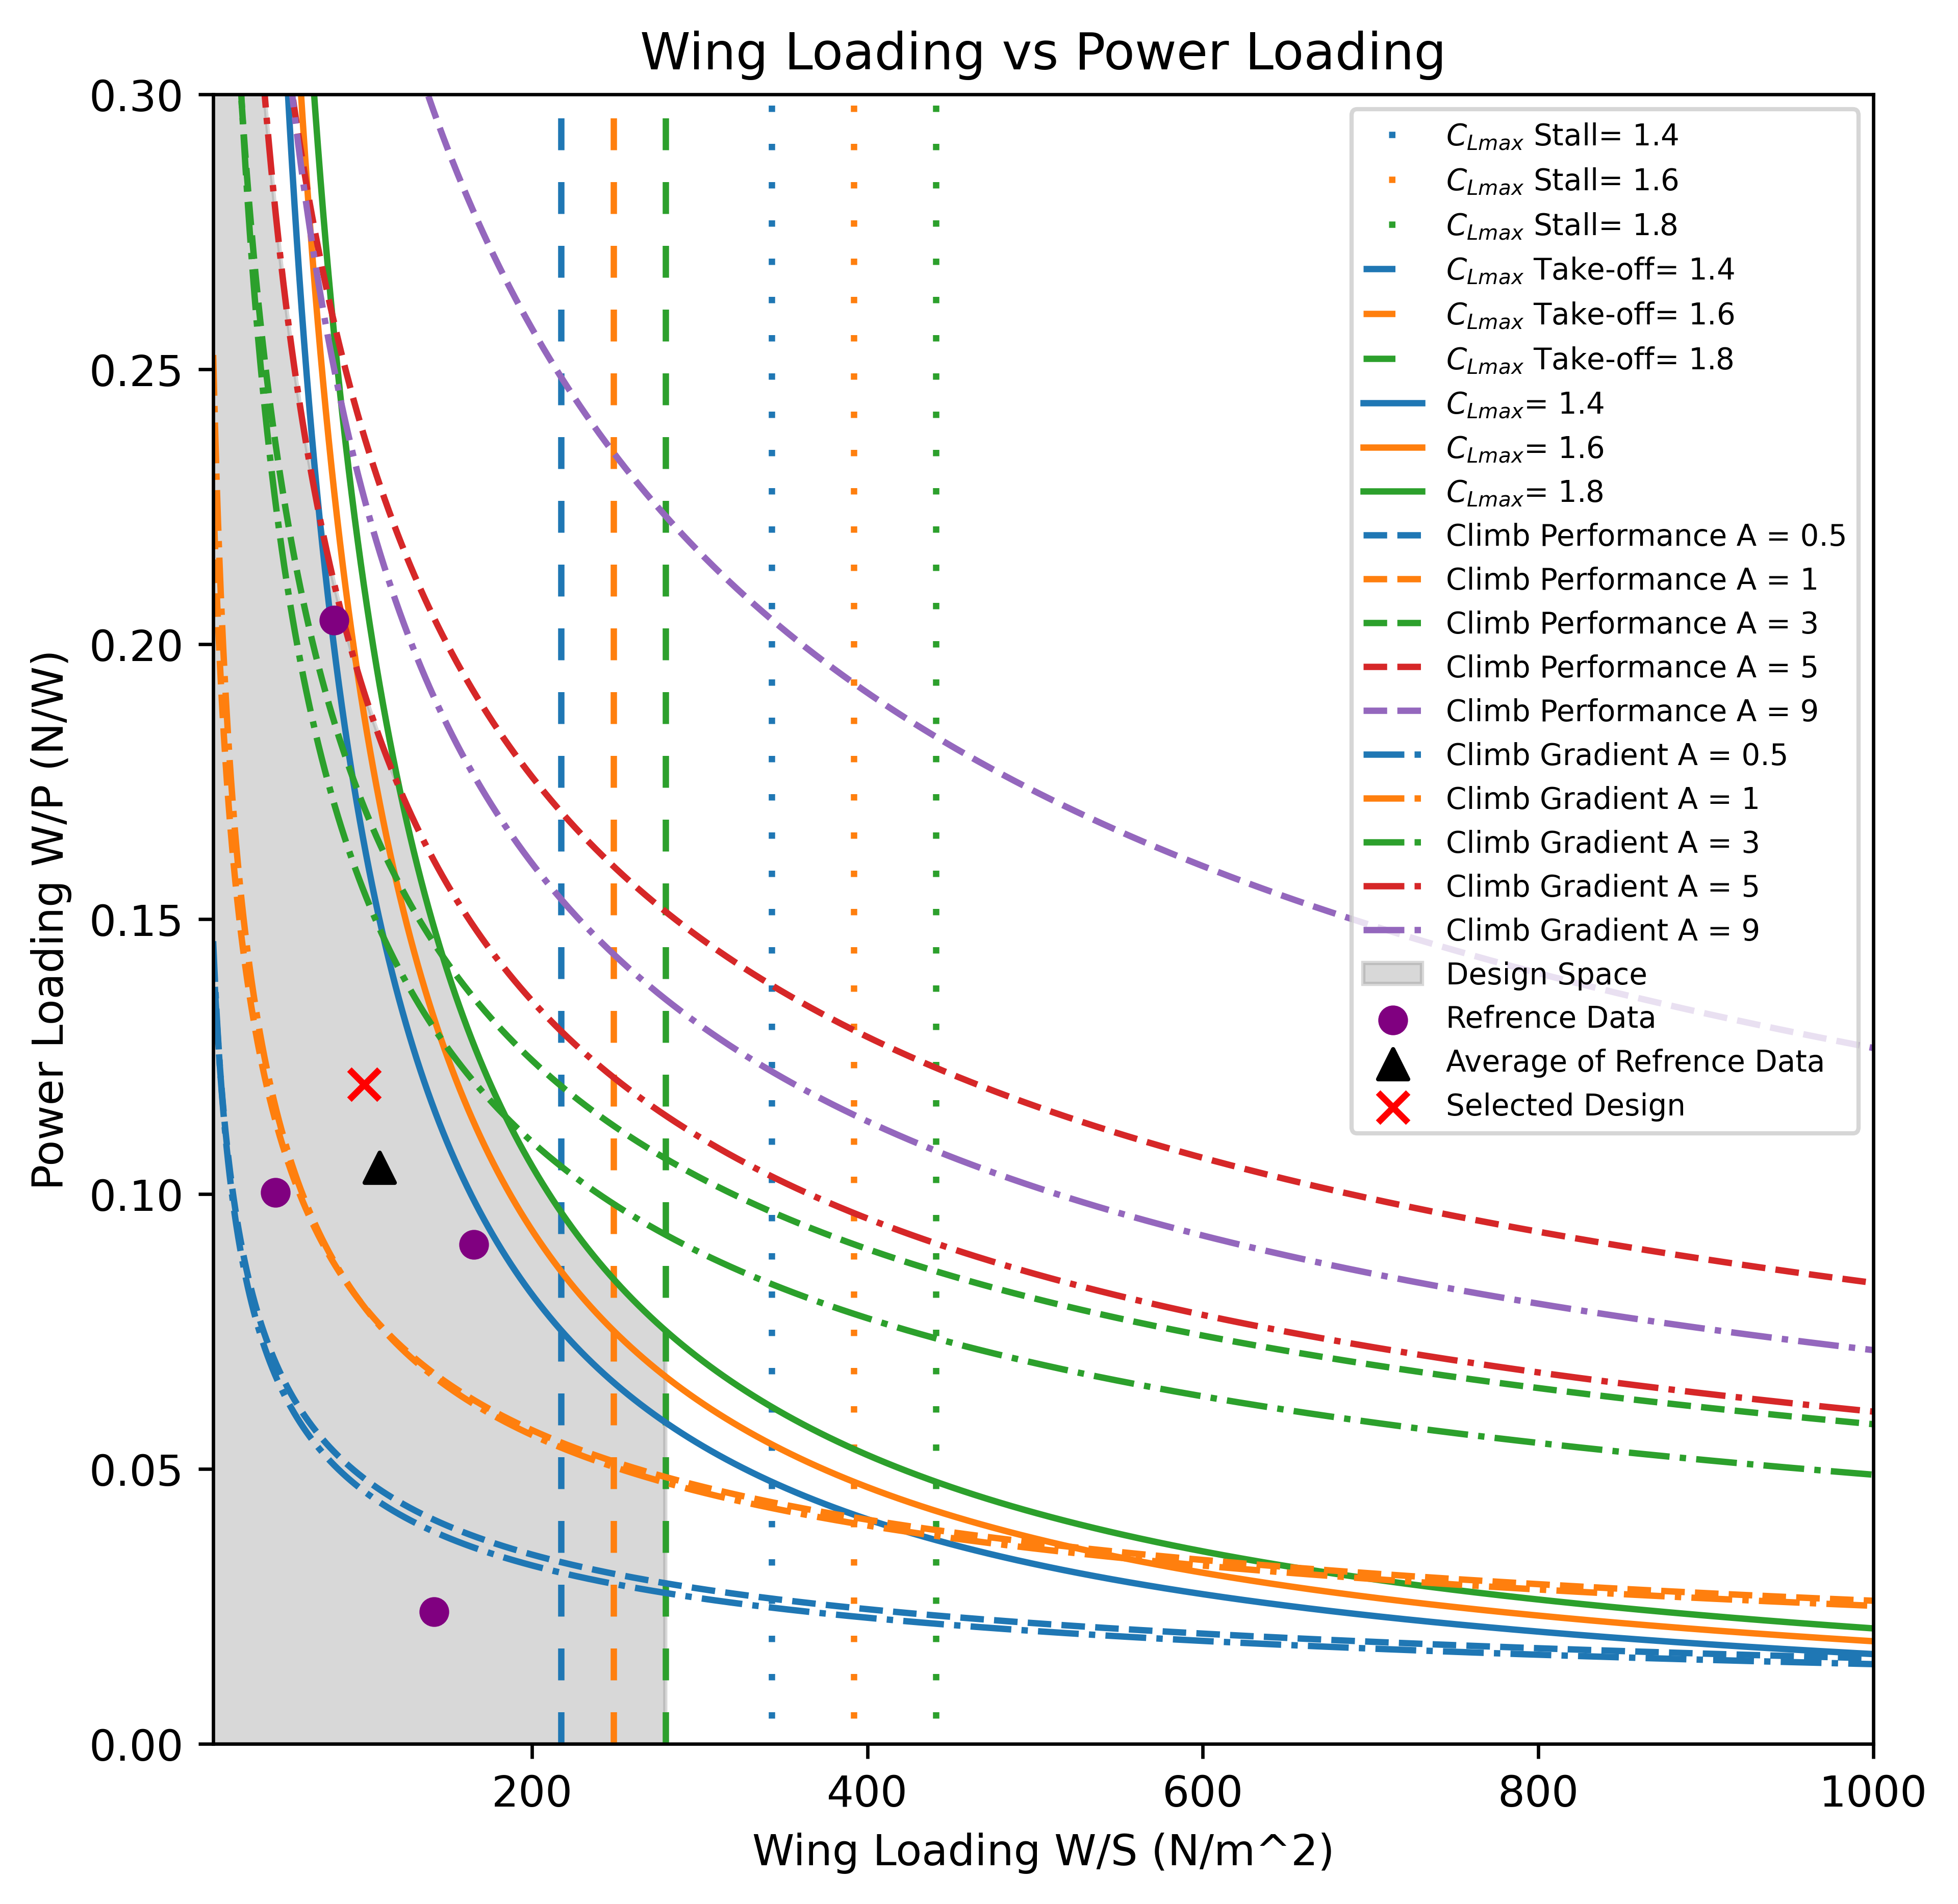

In [137]:
import matplotlib.colors as mcolors


W_S_Selected = 100
W_P_Selected = 0.12

W_s_stall = []
for i in range(len(Clmax)):
    W_s_stall_temp = 0.5*rho*Vs**2*Clmax[i]
    W_s_stall.append(W_s_stall_temp)

W_S = np.arange(1,1000,0.1)
W_P = []
for i in range(len(Clmax)):
    W_p = W_S**-1  * predicted_TOP * Clmax[i] * rho
    W_P.append(W_p)
W_p = W_p

#clmaxto 
W_S_to = []
for i in range(len(Clmax)):
    W_S_to_temp = (Clmax[i]*rho*take_off_distance/.5915)/(2)
    W_S_to.append(W_S_to_temp[0][0])

def calculate_W_over_PR(WS, eta_p, c, rho, A, C_D0,e):
    #W/Pr
    W_over_PR = eta_p / (c + np.sqrt(WS)*np.sqrt(2/rho)*(1/(1.345*((A*e)**.75)/C_D0**.25)))
    
    return W_over_PR
def calculate_W_P_br(WS,c_V,eta_p,rho,A,C_D0,CL):
    #W/Pr
    CD = C_D0 + (CL**2)/(np.pi*A*e)
    W_P_br = eta_p / (np.sqrt(WS)*(c_V+(CD/CL))*np.sqrt((2/rho)*(1/CL)))
    
    return W_P_br
eta_p = 0.8
e = .7
Cd0 = 0.35
A_values = [.5,1,3,5,9]
W_P_R = []
for i in range(len(A_values)):
    W_P_R.append(calculate_W_over_PR(W_S, eta_p, c, rho, A_values[i], Cd0,e))


W_P_BR = []
CL = 1.6
c_V = 0.05
for i in range(len(A_values)):
    W_P_BR.append(calculate_W_P_br(W_S,c_V,eta_p,rho,A_values[i],Cd0,CL))



# WS values
WS_experimental = [
     165.328683,  81.87127183, 
    141.7429248, 47.02682539, 

]

# WP values
WP_experimental = [
     0.090833333,  0.204375, 
     0.024079125, 0.100297518, 

]

WS_experimental = np.array(WS_experimental)

# Color-blind friendly colors and line styles
color_cycle = plt.get_cmap('tab10').colors
line_styles = ['-', '--', '-.', ':']
colors = mcolors.TABLEAU_COLORS

plt.close('all')
plt.figure(figsize=(7,7),dpi=600)

# Plot stall speed line
for i in range(len(W_s_stall)):
    plt.vlines(W_s_stall[i], 0, .5, label='$C_{L max}$ Stall' + f'= {Clmax[i]}', color=color_cycle[i], linestyle=(2, (1, 5)))
for i in range(len(W_S_to)):
    plt.vlines(W_S_to[i], 0, .5, label='$C_{L max}$ Take-off' + f'= {Clmax[i]}', color=color_cycle[i], linestyle=(0, (5, 5)))


# Plot W_p vs W_s for different Clmax
for i, cl in enumerate(Clmax):
    plt.plot(W_S, W_P[i], label='$C_{L max}$' + f'= {cl}', color=color_cycle[i], linestyle=line_styles[0])

# Plot W_P_R for different A values
for i, A in enumerate(A_values):
    plt.plot(W_S, W_P_R[i], label=f'Climb Performance A = {A}', color=color_cycle[i], linestyle=line_styles[1])

# Plot W_P_BR for different A values
for i, A in enumerate(A_values):
    plt.plot(W_S, W_P_BR[i], label=f'Climb Gradient A = {A}', color=color_cycle[i], linestyle=line_styles[2])

# Shade area under clmax 1.8
#make a line that is a peiswise of Climb gradient at A =3 and CLmax = 1.8 whichever is greater
climb_a_3 = W_P_BR[3]
clmax_1_8 = W_P[-1]

W_P_ds = np.minimum(climb_a_3, clmax_1_8)

plt.fill_between(W_S, 0, W_P_ds, where=(W_S < W_S_to[-1]), alpha=0.3, color='gray', label='Design Space')

# Scatter plot experimental data
plt.scatter(WS_experimental, WP_experimental, label='Refrence Data', marker='o', color='purple',zorder = 10)
plt.scatter(np.mean(WS_experimental), np.mean(WP_experimental), label='Average of Refrence Data', color='k', marker='^',s=50, zorder=100)
plt.scatter(W_S_Selected, W_P_Selected, label='Selected Design', color='red', marker='x', s=50)

plt.ylabel('Power Loading W/P (N/W)')
plt.xlabel('Wing Loading W/S (N/m^2)')
plt.ylim(0, .3)
plt.xlim(10,1000)
plt.legend(fontsize='x-small')
plt.title('Wing Loading vs Power Loading')

plt.savefig('Wing_Loading_vs_Power_Loading.png', dpi=600)
plt.show()



c:\Users\Cupri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


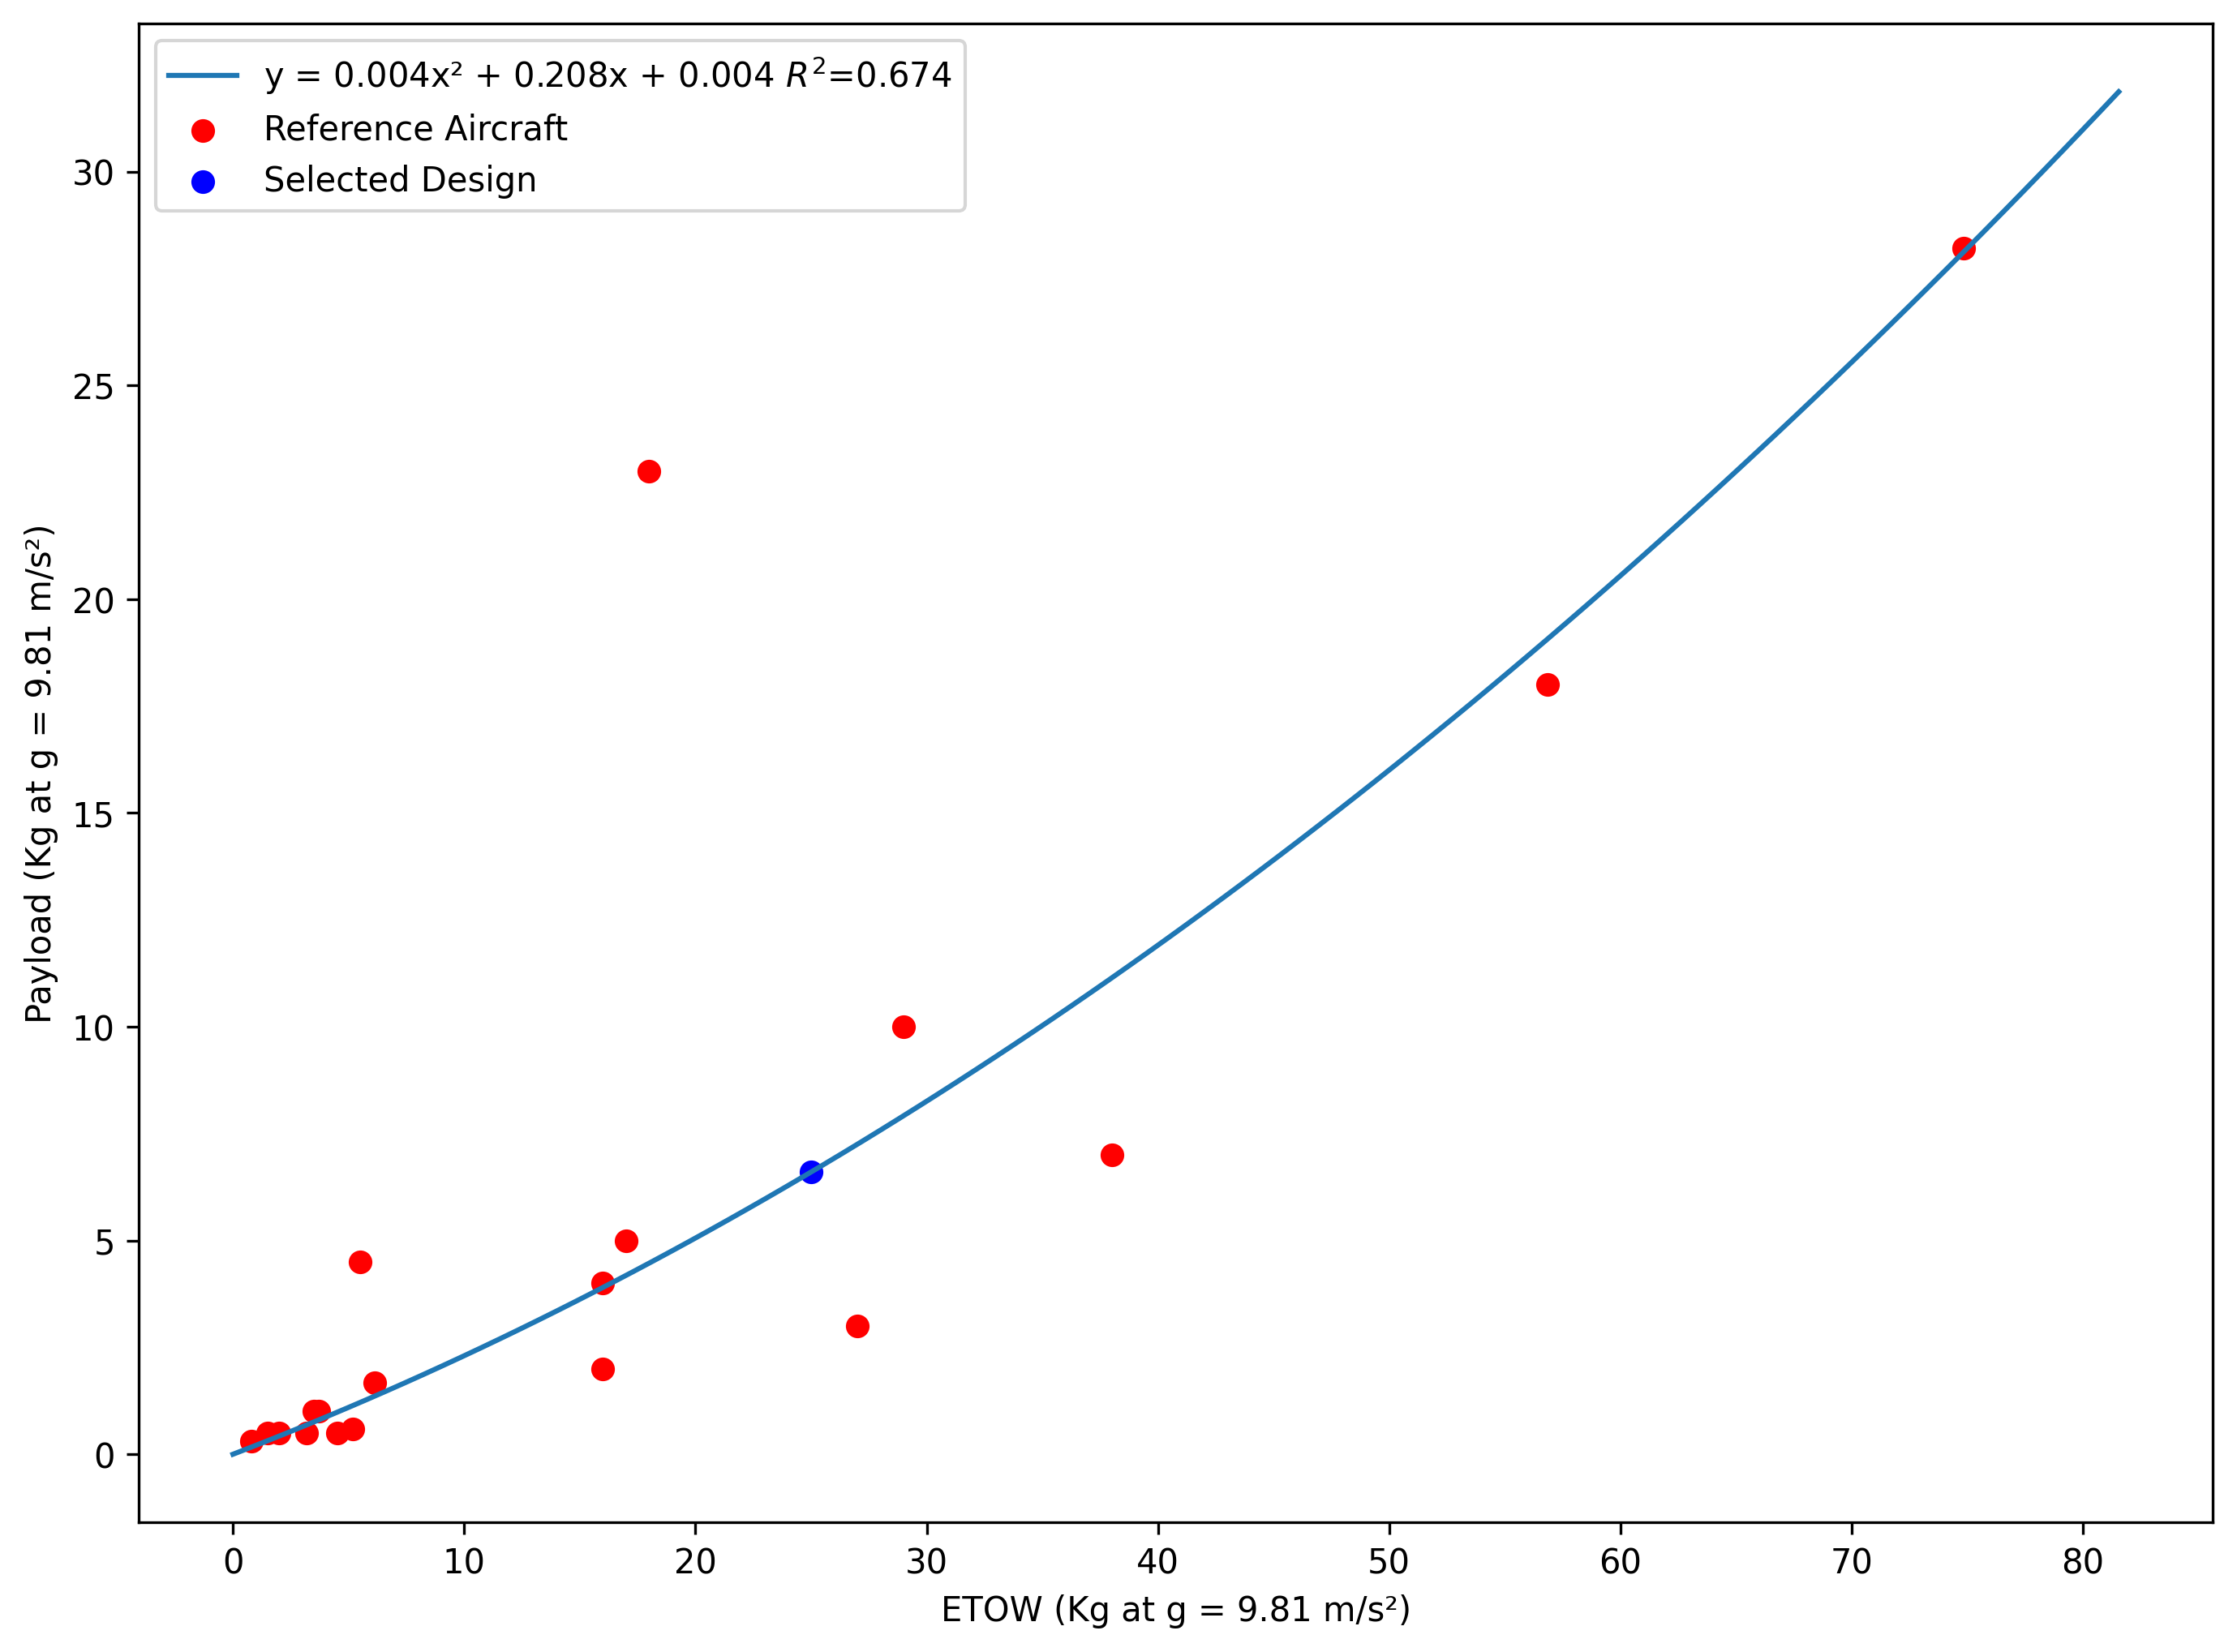

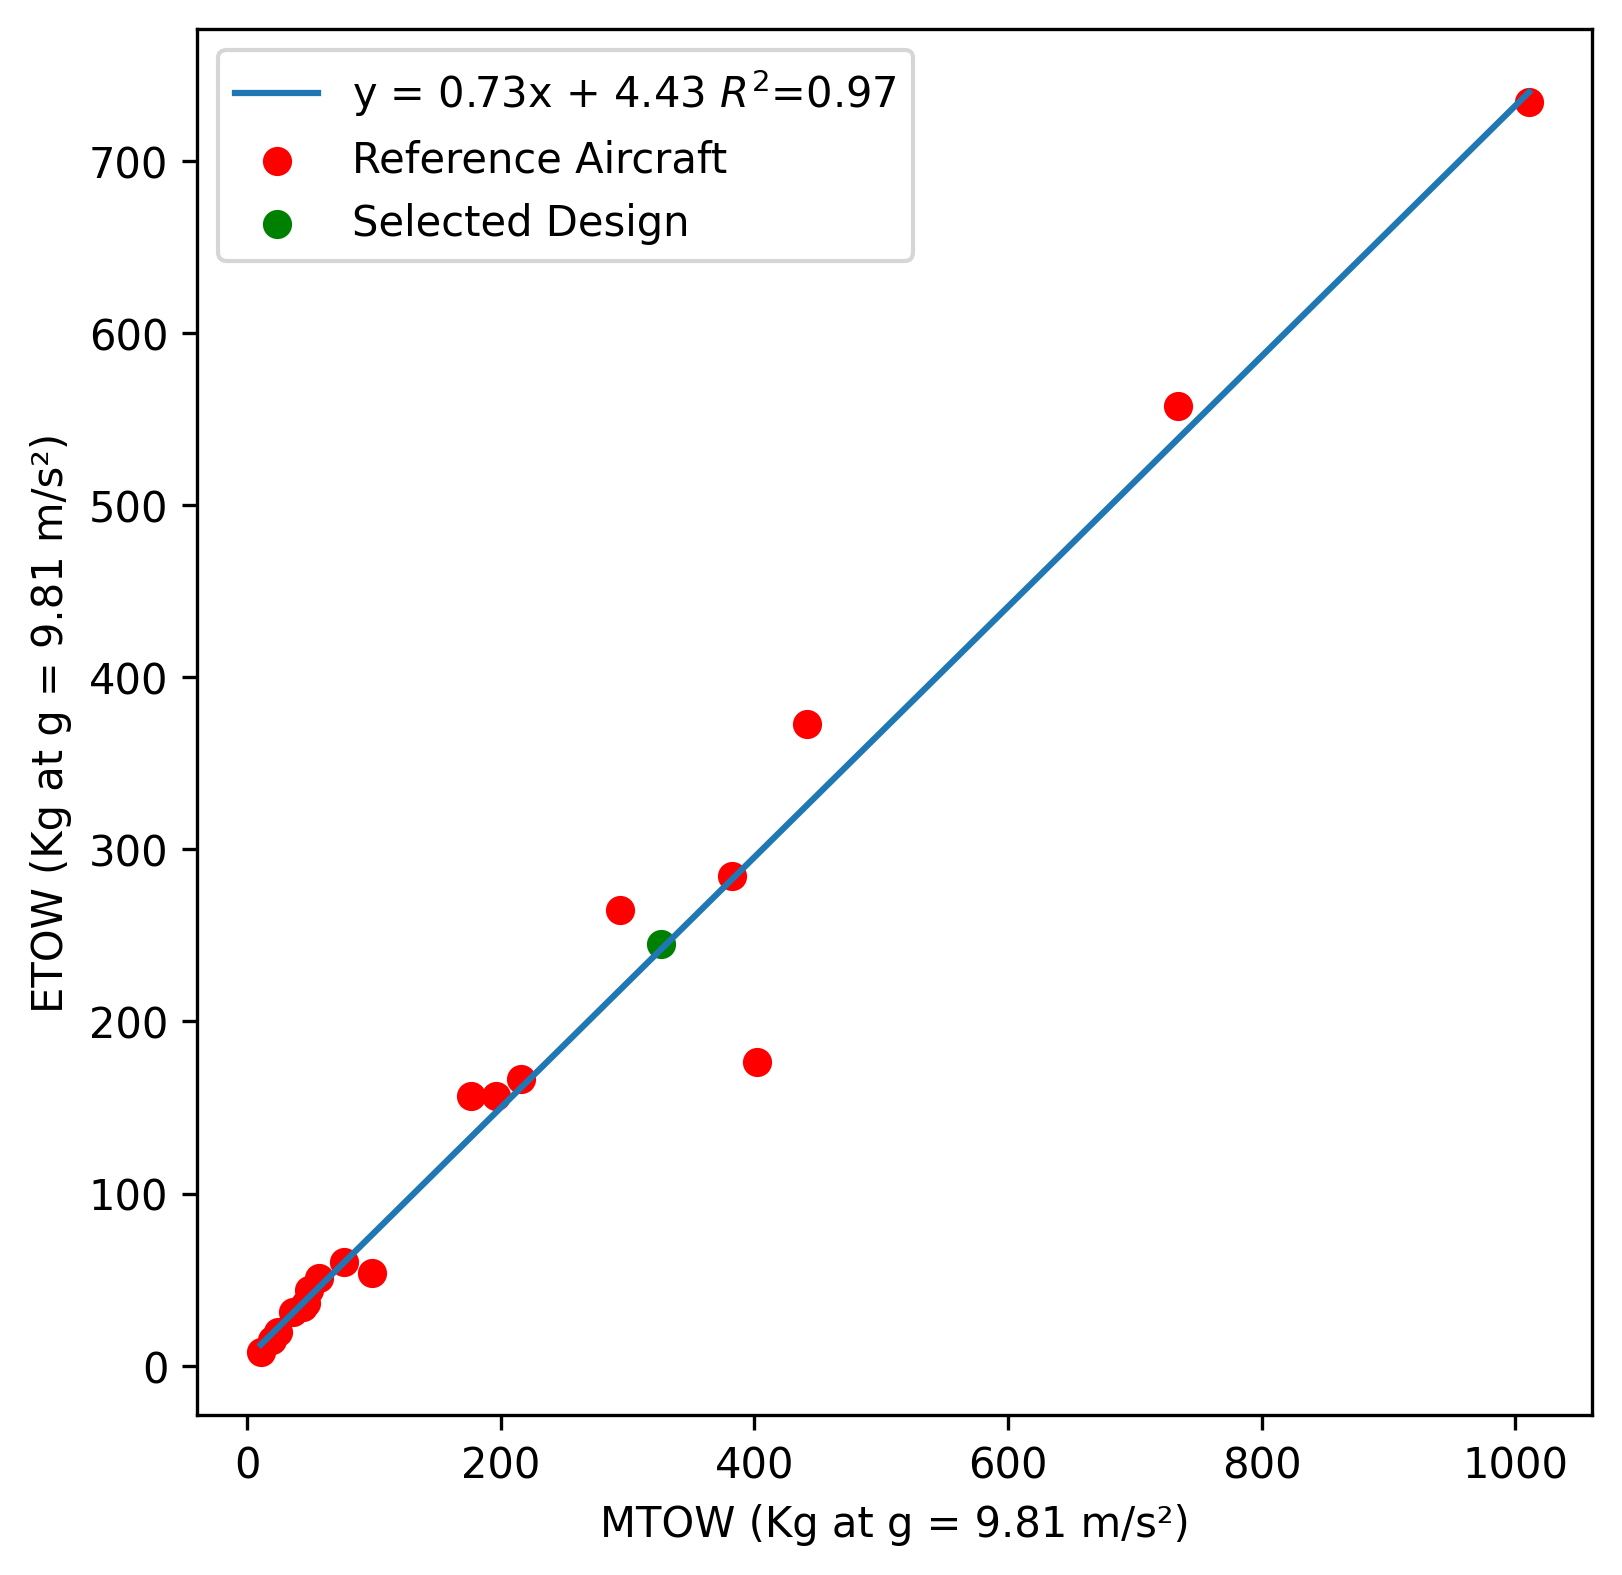

Estimated Payload: 6.601596899170351 Kg
Estimated MTOW: 33.23258568612244 Kg
Estimated ETOW: 25.0 Kg


In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.preprocessing import PolynomialFeatures

# Provided data
MTOW = [98.1, 56.898, 382.59, 196.2, 19.62, 215.82, 49.05, 176.58, 44.145, 36.297, 402.21, 1010.99898, 441.45, 46.107, 294.3, 10.791, 24.525, 76.7142, 734.1804]
ETOW = [53.955, 51.012, 284.49, 156.96, 14.715, 166.77, 44.145, 156.96, 34.335, 31.392, 176.58, 734.1804, 372.78, 36.297, 264.87, 7.848, 19.62, 60.29399245, 557.6004]

MTOW = np.array(MTOW).reshape(-1, 1)
ETOW = np.array(ETOW).reshape(-1, 1)

# Calculate the payload as the difference between MTOW and ETOW
payload = MTOW - ETOW

# Fit a quadratic model for ETOW vs payload
poly = PolynomialFeatures(degree=2)
ETOW_poly = poly.fit_transform(ETOW)

# Fit the model
model_quad = HuberRegressor()
model_quad.fit(ETOW_poly, payload)

# Define the quadratic function
def f_quad(x):
    x_poly = poly.transform(x)
    return model_quad.predict(x_poly)

# Generate space for plotting
x_plot = np.linspace(0, 800, 100).reshape(-1, 1)
y_plot_quad = f_quad(x_plot)

# Estimate ETOW for a specific payload (e.g., 2 kg)
ESTIMATE_ETOW = 25 * 9.81  # example payload in Newtons
estimated_payload = f_quad(np.array([[ESTIMATE_ETOW]]))[0]
# Selected points
selected_MTOW = estimated_payload + ESTIMATE_ETOW + 16

# Plot the data and the quadratic curve
plt.figure(figsize=(6,6), dpi=300)
plt.plot(x_plot / 9.81, y_plot_quad / 9.81, label=f'y = {model_quad.coef_[0]:.3f}x² + {model_quad.coef_[1]:.3f}x + {model_quad.intercept_:.3f} $R^2$={model_quad.score(ETOW_poly, payload):.3f}')
plt.scatter(ETOW / 9.81, payload / 9.81, color='red', label='Reference Aircraft')
plt.scatter(ESTIMATE_ETOW / 9.81, estimated_payload / 9.81, color='blue', label='Selected Design')
plt.xlabel('ETOW (Kg at g = 9.81 m/s²)')
plt.ylabel('Payload (Kg at g = 9.81 m/s²)')
plt.legend()
plt.savefig('ETOW_vs_Payload.png', dpi=300)
plt.show()

# Fit a linear model for MTOW vs ETOW
model_linear = LinearRegression()
model_linear.fit(MTOW, ETOW)

# Get coefficients and intercept for linear model
b_linear = model_linear.coef_[0][0]
c_linear = model_linear.intercept_[0]

# Define the linear function for MTOW
def f_linear(x):
    return b_linear * x + c_linear

# Generate linear space for plotting MTOW vs ETOW
x_plot_mtow = np.linspace(MTOW.min(), MTOW.max(), 100).reshape(-1, 1)
y_plot_mtow = f_linear(x_plot_mtow)

# Plot the data and the regression line for MTOW vs ETOW
plt.figure(figsize=(6,6), dpi=300)
plt.plot(x_plot_mtow, y_plot_mtow, label=f'y = {b_linear:.2f}x + {c_linear:.2f} $R^2$={model_linear.score(MTOW, ETOW):.2f}')
plt.scatter(MTOW, ETOW, color='red', label='Reference Aircraft')
plt.scatter(selected_MTOW, ESTIMATE_ETOW, color='green', label='Selected Design')
plt.xlabel('MTOW (Kg at g = 9.81 m/s²)')
plt.ylabel('ETOW (Kg at g = 9.81 m/s²)')
plt.legend()
plt.savefig('MTOW_vs_ETOW.png', dpi=300)
plt.show()

print(f'Estimated Payload: {estimated_payload / 9.81} Kg')
print(f'Estimated MTOW: {selected_MTOW/ 9.81} Kg')
print(f'Estimated ETOW: {ESTIMATE_ETOW / 9.81} Kg')
Selected_MTOW = selected_MTOW



L/D max: 6.86


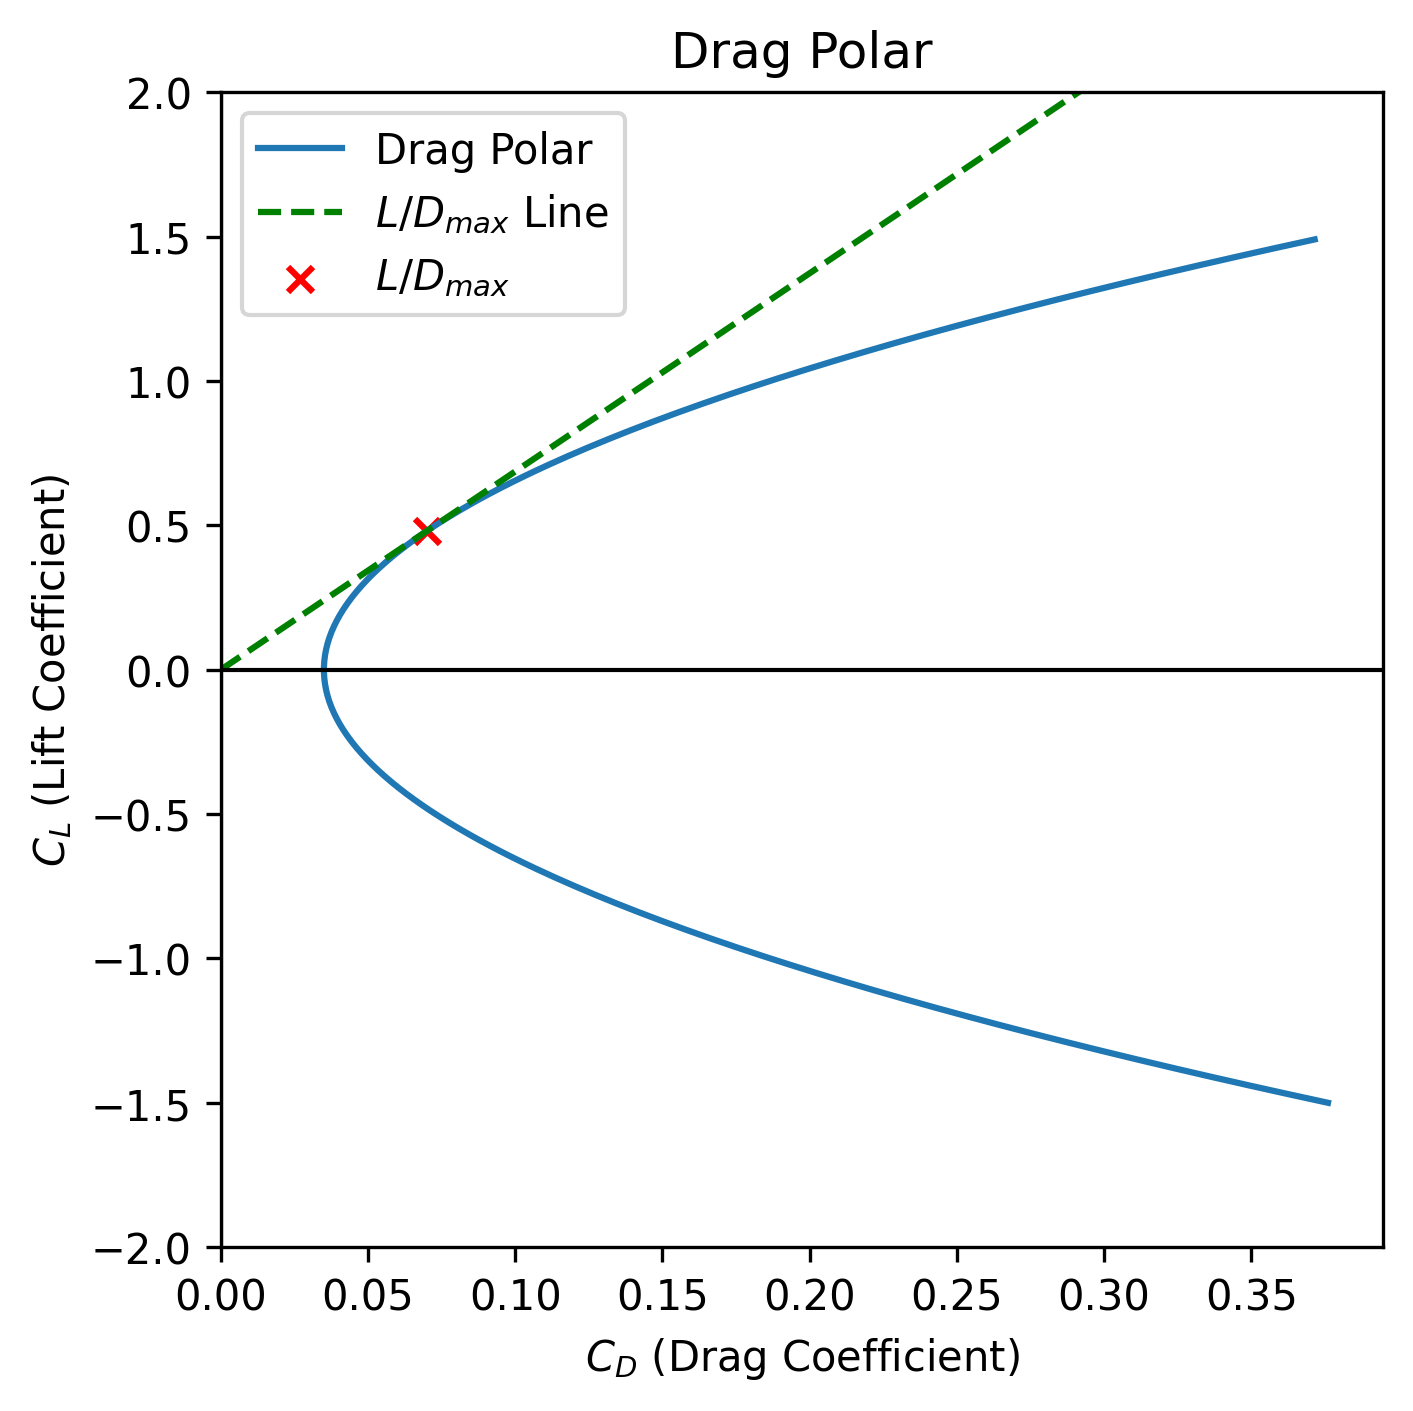

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (assumed values for Cd0 and e, feel free to adjust)
Cd0 = 0.035  # Zero-lift drag coefficient
e = 0.7     # Oswald efficiency factor
A = 3      # Aspect ratio

# CL range
CL = np.arange(-1.5, 1.5, 0.01)

# Calculate CD
CD = Cd0 + CL**2 / (np.pi * A * e)
# Calculate L/D and find L/Dmax
L_D = CL / CD
L_Dmax = np.max(L_D)
CD_LDmax = CD[np.argmax(L_D)]
CL_LDmax = CL[np.argmax(L_D)]

# Print L/Dmax for reference
print(f"L/D max: {L_Dmax:.2f}")

plt.figure(figsize=(5,5), dpi=300)

# Plot drag polar
plt.plot(CD, CL, label="Drag Polar")

# Extend the L/D line past L/Dmax by calculating slope and extending it
slope = CL_LDmax / CD_LDmax

# Define extended range for CD and corresponding CL values using the slope
CD_extended = np.linspace(0, CD_LDmax * 5, 100)  # Extend up to 1.5 times the CD_LDmax
CL_extended = slope * CD_extended  # Linear relationship CL = slope * CD


# Plot the extended L/D max line from origin to extended points
plt.plot(CD_extended, CL_extended, color='green', linestyle='--', label='$L/D_{max}$ Line')

# Scatter plot the L/D max point
plt.scatter(CD_LDmax, CL_LDmax, color='red', marker='x', label='$L/D_{max}$')

# Label major points
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('$C_D$ (Drag Coefficient)')
plt.ylabel('$C_L$ (Lift Coefficient)')
plt.title('Drag Polar')
plt.xlim(left=0)  # Ensures x-axis starts at zero
plt.ylim(-2, 2)   # Reasonable range for CL
plt.legend()
plt.savefig('Drag_Polar.png', dpi=300)
# Show plot
plt.show()

#cd at cl = 1.8
cl = 1.8
cd = Cd0 + cl**2 / (np.pi * A * e)


In [123]:
#Power required
Pr = (W_P_Selected**-1 * Selected_MTOW)
S = (W_S_Selected**-1 * Selected_MTOW)

print(f"Design W/S = {W_S_Selected} N/m^2")
print(f"Design W/P = {W_P_Selected} N/W")
print(f"Design MTOW = {Selected_MTOW/9.81} Kg")
print(f"Design Pr = {Pr} W")
print(f"Design S = {S} m^2")

efficiency = [7.5,6.9,6.0,5.4,5.1]
throttle  = [30,35,40,45,50]

#engine scaling
#selected engine parameters
ref_engine_W_at_40percent_throttle = 3390 #W
ref_engine_D = 144.2/1000 #m

#scaling factor

#scaled engine parameters
scaled_engine_D = ref_engine_D * (Pr/ref_engine_W_at_40percent_throttle)**(1/3)

print(f"Scaled Engine Power = {Pr} W")
print(f"Scaled Engine Diameter = {scaled_engine_D} m")
print(f"Scaling Factor = {scaled_engine_D/ref_engine_D}")




Design W/S = 100 N/m^2
Design W/P = 0.15 N/W
Design MTOW = 33.23258568612244 Kg
Design Pr = 2173.411103872408 W
Design S = 3.260116655808612 m^2
Scaled Engine Power = 2173.411103872408 W
Scaled Engine Diameter = 0.12434051299711187 m
Scaling Factor = 0.8622781761242154


In [117]:
import math
def electric_range_in_ah(C_b, V_bat, P_avg, V):
    """
    Calculate the range for electric aircraft in terms of ampere-hours.
    
    Parameters:
    C_b : float : Battery capacity (Ah)
    V_bat : float : Battery voltage (V)
    P_avg : float : Average power consumption (W)
    V : float : True airspeed during cruise (m/s or knots)
    
    Returns:
    R : float : Range (in km)
    """
    # Convert Ah to Wh
    E_b = C_b * V_bat  # Energy capacity in Wh
    return (E_b / P_avg) * V  # Range in km

def electric_endurance_in_ah(C_b, V_bat, P_avg):
    """
    Calculate the endurance for electric aircraft in terms of ampere-hours.
    
    Parameters:
    C_b : float : Battery capacity (Ah)
    V_bat : float : Battery voltage (V)
    P_avg : float : Average power consumption (W)
    
    Returns:
    E : float : Endurance (in hours)
    """
    # Convert Ah to Wh
    E_b = C_b * V_bat  # Energy capacity in Wh
    return E_b / P_avg  # Endurance in hours


# Example usage for electric aircraft:
C_b = 80  # Battery capacity 
V_bat = 48  # Battery voltage in V (24 V)
V = 15  # True airspeed in m/s
P_avg = 1.22  * 1000
# Calculate range and endurance
range_electric = electric_range_in_ah(C_b, V_bat, P_avg, V)
endurance_electric = electric_endurance_in_ah(C_b, V_bat, P_avg)

print(f"Electric Aircraft Range: {range_electric:.2f} km")  # Range in km
print(f"Electric Aircraft Endurance: {endurance_electric:.2f} hours")  # Endurance in hours

# Example usage for power required in cruise (remains unchanged):
def power_required_cruise(CD, CL, W, V):
    """
    Calculate the power required in cruise for an aircraft.
    
    Parameters:
    CD : float : Drag coefficient
    CL : float : Lift coefficient
    W : float : Aircraft weight (N or lb)
    V : float : Cruise velocity (m/s or knots)
    
    Returns:
    P_cruise : float : Power required in cruise (Watts or HP)
    """
    return (CD / CL) * W * V

# Example usage for power required in cruise:
CD = 0.45  # Drag coefficient
CL = 1.8
W = Selected_MTOW
V = 15  # m/s

power_cruise = power_required_cruise(CD, CL, W, V)
print(f"Power required in cruise: {power_cruise / 1000:.2f} kW")  # Convert to kW

def calculate_min_speed(weight, S, CL, air_density=1.225):
    """
    Calculate the minimum speed required to keep the aircraft in the air.
    
    Parameters:
    weight : float : Weight of the aircraft (N)
    S : float : Wing area (m²)
    CL : float : Lift coefficient (dimensionless)
    air_density : float : Air density (kg/m³), default is 1.225 kg/m³ at sea level
    
    Returns:
    V_min : float : Minimum speed required to maintain level flight (m/s)
    """
    V_min = math.sqrt((2 * weight) / (air_density * S * CL))
    return V_min

# Example parameters
S_wing = 3  # Wing area in m² (example value)
CL_cruise = 1.8  # Lift coefficient (example value)
V = calculate_min_speed(Selected_MTOW, S_wing, CL_cruise)
print(f"Minimum speed required: {V:.2f} m/s")  # Minimum speed in m/s

Electric Aircraft Range: 47.21 km
Electric Aircraft Endurance: 3.15 hours
Power required in cruise: 1.22 kW
Minimum speed required: 9.93 m/s


In [105]:
#